In [1]:
import numpy as np
import pandas as pd
import scipy
import os
import tensorflow as tf
from Metric_Computation import *

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data and Split

In [2]:
# specify the path to read
data_load_path = '../data/intermediate/'
# read the data
data_input_X = np.load(data_load_path+'data_X.npy')
data_input_X_prev = np.load(data_load_path+'data_X_prev.npy')
SP500_input_X = np.load(data_load_path+'SP500.npy')
SP500_input_X_prev = np.load(data_load_path+'SP500_prev.npy')
value_target = np.load(data_load_path+'target_value.npy')
value_target_prev = np.load(data_load_path+'target_value_prev.npy')
gradient_target = np.load(data_load_path+'target_gradient.npy')
gradient_target_prev = np.load(data_load_path+'target_gradient_prev.npy')
trend_target = np.load(data_load_path+'price_trend_flag.npy')

In [3]:
# drop some really weird stock gradient entries
# valid_stock_index = np.where((np.absolute(gradient_target)<=7.0)&(np.absolute(gradient_target_prev)<=7.0))[0]
# data_input_X = data_input_X[valid_stock_index,:,:]
# data_input_X_prev = data_input_X_prev[valid_stock_index,:,:]
# SP500_input_X = SP500_input_X[valid_stock_index,:]
# SP500_input_X_prev = SP500_input_X_prev[valid_stock_index,:]
# value_target = value_target[valid_stock_index,:]
# value_target_prev = value_target_prev[valid_stock_index,:]
# gradient_target = gradient_target[valid_stock_index,:]
# gradient_target_prev = gradient_target_prev[valid_stock_index,:]

In [4]:
# drop instance that contains inf values
valid_series_index = np.where((np.sum(np.sum(data_input_X,axis=-1),axis=-1)!=np.inf)&((np.sum(np.sum(data_input_X_prev,axis=-1),axis=-1)!=np.inf)))[0]
data_input_X = data_input_X[valid_series_index,:,:]
data_input_X_prev = data_input_X_prev[valid_series_index,:,:]
SP500_input_X = SP500_input_X[valid_series_index,:]
SP500_input_X_prev = SP500_input_X_prev[valid_series_index,:]
value_target = value_target[valid_series_index,:]
value_target_prev = value_target_prev[valid_series_index,:]
gradient_target = gradient_target[valid_series_index,:]
gradient_target_prev = gradient_target_prev[valid_series_index,:]
trend_target = trend_target[valid_series_index, :]

In [5]:
# split the data
ind_permutation = np.random.permutation(data_input_X.shape[0])
# training and testing index
training_ind = ind_permutation[:ind_permutation.shape[0]//2]
validation_ind = ind_permutation[ind_permutation.shape[0]//2:ind_permutation.shape[0]*3//4]
testing_ind = ind_permutation[ind_permutation.shape[0]*3//4:]
# indexing the data
# time series data
# training
data_train_X = data_input_X[training_ind,:,:]
data_train_X_prev = data_input_X_prev[training_ind,:,:]
# validation
data_valid_X = data_input_X[validation_ind,:,:]
data_valid_X_prev = data_input_X[validation_ind,:,:]
# test
data_test_X = data_input_X[testing_ind,:,:]
data_test_X_prev = data_input_X_prev[testing_ind,:,:]
# SP500 info
# train
SP500_train_X = np.reshape(SP500_input_X[training_ind],[-1,1])
SP500_train_X_prev = np.reshape(SP500_input_X_prev[training_ind],[-1,1])
# validation
SP500_valid_X = np.reshape(SP500_input_X[validation_ind],[-1,1])
SP500_valid_X_prev = np.reshape(SP500_input_X_prev[validation_ind],[-1,1])
# test
SP500_test_X = np.reshape(SP500_input_X[testing_ind],[-1,1])
SP500_test_X_prev = np.reshape(SP500_input_X_prev[testing_ind],[-1,1])
# value prediction (for reference usage only)
# train
value_target_train = np.reshape(value_target[training_ind],[-1,1])
value_target_train_prev = np.reshape(value_target_prev[training_ind],[-1,1])
# validation
value_target_valid = np.reshape(value_target[validation_ind],[-1,1])
value_target_valid_prev = np.reshape(value_target_prev[validation_ind],[-1,1])
# test
value_target_test = np.reshape(value_target[testing_ind],[-1,1])
value_target_test_prev = np.reshape(value_target_prev[testing_ind],[-1,1])
# gradient prediction (the real 'labels' for training)
# train
gradient_target_train = np.reshape(gradient_target[training_ind],[-1,1])
gradient_target_train_prev = np.reshape(gradient_target_prev[training_ind],[-1,1])
# validation
gradient_target_valid = np.reshape(gradient_target[validation_ind],[-1,1])
gradient_target_valid_prev = np.reshape(gradient_target_prev[validation_ind],[-1,1])
# test
gradient_target_test = np.reshape(gradient_target[testing_ind],[-1,1])
gradient_target_test_prev = np.reshape(gradient_target_prev[testing_ind],[-1,1])
# trend info
# train
trend_target_train = np.reshape(trend_target[training_ind],[-1,1])
# validation
trend_target_valid = np.reshape(trend_target[validation_ind],[-1,1])
# test
trend_target_test = np.reshape(trend_target[testing_ind],[-1,1])

In [6]:
current_and_future_price_train = np.concatenate([value_target_train_prev, value_target_train],axis=1)
current_and_future_price_valid = np.concatenate([value_target_valid_prev, value_target_valid],axis=1)
current_and_future_price_test = np.concatenate([value_target_test_prev, value_target_test],axis=1)

### preceed the trend(class) target to one-hot

In [7]:
def one_hot_encoding_label(label_input, num_class=None):
    '''
    :param label_input: The sparse form of input label (2,0,1,3,0,1,2etc.)
    :param num_class: The number of classes, if keep None, then automatically infer from the given label input
    '''
    # retrieve the number of input data
    nData = label_input.shape[0]
    # reshape the data
    label_input_flat = np.reshape(label_input, [-1])
    if (label_input_flat.shape[0]!=nData):            # which means the input label is not 'mathematically 1-d'
        raise ValueError('The input label must be 1-d mathematically')
    # infer the number of class if input is None
    if num_class is None:
        num_class = (int)(np.amax(label_input)+1)
    # create the return encoded matrx
    one_hot_label_mat = np.zeros([nData, num_class])
    # get a row index to assist the batch-assigning
    row_ind_batch = np.arange(nData)
    # assign '1's to the corresponding positions
    one_hot_label_mat[row_ind_batch, label_input_flat.astype('int')] = 1
    
    return one_hot_label_mat

In [8]:
trend_target_train_input = one_hot_encoding_label(trend_target_train)
trend_target_valid_input = one_hot_encoding_label(trend_target_valid)
trend_target_test_input = one_hot_encoding_label(trend_target_test)

## Evaluation Functions

In [9]:
# confusion metrics
def classification_info_computation(pred_label, true_label, num_class):
    '''
    :param pred_label: the sparse (not one-hot) prediction of labels
    :param true_label: the sparse (not one-hot) ground-truth of labels
    :param num_class: number of classes
    '''
    # flatten the two label arrays if they are not already so
    pred_label = np.reshape(pred_label,[-1])
    true_label = np.reshape(true_label,[-1])
    # initialize the confusion maxtrix array
    class_matrix = np.zeros([num_class, num_class])    # each row is the true labels
    # initialize the precision and recall arrays
    precision_array = np.zeros([num_class])
    recall_array = np.zeros([num_class])
    # fill the confusion-prediction matrix
    for cClass_True in range(num_class):
        # retrieve the current 
        current_cClass_ind = np.where(true_label==cClass_True)[0]
        # retrueve the corresponding predictions
        current_cClass_pred = pred_label[current_cClass_ind]
        # fill the evaluation matrx
        for cClass_Pred in range(num_class):
            cClass_pred_num = np.where(current_cClass_pred==cClass_Pred)[0].shape[0]
            class_matrix[cClass_True, cClass_Pred] = cClass_pred_num
    # fill the precision and recall arrays
    for cClass_True in range(num_class):
        precision_array[cClass_True] = class_matrix[cClass_True,cClass_True]/np.sum(class_matrix[:,cClass_True])
        recall_array[cClass_True] = class_matrix[cClass_True,cClass_True]/np.sum(class_matrix[cClass_True,:])
        
    return class_matrix, precision_array, recall_array

In [10]:
# 'regret' function
def invest_regret_comput(pred_label, true_label):
    '''
    The function to return the 'regret' defined by the real investment scenarios
    :param pred_label: the sparse (not one-hot) prediction of labels
    :param true_label: the sparse (not one-hot) ground-truth of labels
    With the meaning 2=uptrend 1=downtrend 0=non-trend
    Strategy: 
        predict 0: don't buy or sell
        predict 1: sell
        predict 2: buy
    ******************** Truth Table *********************
    | True Label | Predicted Label | Regret |
    |      0     |        0        |   0    |
    |      0     |        1        |   1    |
    |      0     |        2        |   1    |
    |      1     |        0        |   1    |
    |      1     |        1        |   0    |
    |      1     |        2        |   2    |
    |      2     |        0        |   1    |
    |      2     |        1        |   2    |
    |      2     |        2        |   0    |
    '''
    # flatten the two label arrays if they are not already so
    pred_label = np.reshape(pred_label,[-1])
    true_label = np.reshape(true_label,[-1])
    # check if the two arrays are of the same legth
    if pred_label.shape[0]!=true_label.shape[0]:
        raise ValueError('The predicted and the true labels must be in the same length!')
    # placeholder of regret array
    regret_array = np.zeros([pred_label.shape[0]])
    # check the conditions for regret '1'
    one_regret_ind = np.where(((true_label==0)&(pred_label==2))|((true_label==0)&(pred_label==1))|((true_label==2)&(pred_label==0))|((true_label==1)&(pred_label==0)))[0]
    # check the conditions for regret '2'
    two_regret_ind = np.where(((true_label==1)&(pred_label==2))|((true_label==2)&(pred_label==1)))[0]
    # assign regret values to the entries
    regret_array[one_regret_ind] = 1.0
    regret_array[two_regret_ind] = 2.0
    # compute the overall regret
    overall_regret = np.mean(regret_array)
    
    return overall_regret

## Hyper-parameters of the RNN

In [11]:
# rnn cell sequence length and dimensions
nChunck = data_input_X.shape[1]
nDim = data_input_X.shape[2]
# output dimension
nClass = 3
# number of nested RNN stack
nStack_rnn = 5
# rnn dimension
rnn_size = 64
# training hyper-parameter
nEpochs = 100
batch_size = 256
pred_loss_coeff = 1e-3
l2_FC_pen_coeff = 1e-3
fluc_pen_coeff = 1e-4
learning_rate = 1e-4
tol = 1e-3
focal_gamma = 3.0     # parameter for the focal loss
trend_weight_alpha = 2.0  # parameter to encourage output 1/2
# data info for feeding them
nData_train = data_train_X.shape[0]
nData_test = data_test_X.shape[0]

## A 'Erease Graph' here to enable us to re-run things

In [42]:
tf.reset_default_graph()

## Code to save the model

In [43]:
Model_path = '../model/trend_bidirec_RNN/'
#Model saving function
def tf_save_model(session):
    if not os.path.exists(Model_path):
        os.makedirs(Model_path)
    saver = tf.train.Saver()
    saver.save(session, Model_path+'Bidirec_RNN.checkpoint')

## define the RNN graph

In [44]:
#Get the x input as float and reshape input
x_time_series = tf.placeholder("float",[None,nChunck,nDim])       # Batch_size * n_chunk * chunk_size
x_time_series_prev = tf.placeholder("float",[None,nChunck,nDim])  # Batch_size * n_chunk * chunk_size
x_SP_data = tf.placeholder("float",[None,1])                      # Batch_size * 1
x_SP_data_prev = tf.placeholder("float",[None,1])                 # Batch_size * 1
x_current_price = tf.placeholder("float",[None,2])                # Batch_size * 2
y = tf.placeholder("float",[None,1])                              # Batch_size * 1
y_prev = tf.placeholder("float",[None,1])                         # Batch_size * 1
y_trend = tf.placeholder("float",[None,nClass])                   # Batch_size * n_classes

In [45]:
def swish_activation(data_input):
    '''
    Swish activation, by Ramachandran et al., Google Brain, 2017
    The activation is found by a RNN-based combinational search, and it has been proved consistently outperforming
        RELU on networks like NASNet-A and Inception-ResNet-v2
    '''
    # define the beta variable as trainable
    para_beta = tf.Variable(tf.random_uniform([1]))
    swish_output = data_input*tf.sigmoid(para_beta*data_input)
    
    return swish_output

In [46]:
def Recurrent_neural_network(x_time_series, x_SP_data, x_time_series_prev, x_SP_data_prev, x_current_price):
    # process the data concatenating the current and previous data
    data_processed = tf.concat([x_time_series,x_time_series_prev],axis=0)
    # split the data into (nChunck * [batch_size, nDim])       
    data_processed = tf.split(data_processed, num_or_size_splits=nChunck, axis=1)  # (nChunck * [batch_size, nDim])
    data_processed = [tf.squeeze(this_time_data, axis=1) for this_time_data in data_processed]
    # define individual GRU cells
    # forward
    stack_GRU_cell_forward = []
    for _ in range(nStack_rnn):
        current_rnn_cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(rnn_size),
                                                         input_keep_prob=0.7,
                                                         variational_recurrent=False)# ,
#                                                          input_size=nDim,
#                                                          dtype=tf.float32)
        stack_GRU_cell_forward.append(current_rnn_cell)
    heiarchy_RNN_forward = tf.contrib.rnn.MultiRNNCell(stack_GRU_cell_forward)
    # backward
    stack_GRU_cell_backward = []
    for _ in range(nStack_rnn):
        current_rnn_cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(rnn_size),
                                                         input_keep_prob=0.7,
                                                         variational_recurrent=False)#,
#                                                          input_size=nDim,
#                                                          dtype=tf.float32)
        stack_GRU_cell_backward.append(current_rnn_cell)
    heiarchy_RNN_backward = tf.contrib.rnn.MultiRNNCell(stack_GRU_cell_backward)
    # output of the forward-backword RNN
    outputs_all, output_for_final, output_back_final = tf.contrib.rnn.static_bidirectional_rnn(cell_fw=heiarchy_RNN_forward,
                                                                                               cell_bw=heiarchy_RNN_backward,
                                                                                               inputs=data_processed,
                                                                                               dtype=tf.float32)
    # Post-RNN process
    # concatenate the current and prev S&P-500
    x_SP_data_processed = tf.concat([x_SP_data,x_SP_data_prev],axis=0)
    # [nBatch x 2*rnn_stack*rnn_size+1]
    # print(outputs_all[-1].get_shape().as_list())
    out_status_processed = tf.concat([outputs_all[-1], x_SP_data_processed],axis=1)   # [batch_size x (2*rnn_size+1)]
    with tf.name_scope("FC_layers_rate"):
        weight_FC_rate = {'weight_hidden': tf.Variable(tf.random_normal([2*rnn_size+1, 64])),
                     'weight_out': tf.Variable(tf.random_normal([64, 1]))}
    with tf.name_scope("FC_layers_scale"):
        weight_FC_scale = {'weight_hidden': tf.Variable(tf.random_normal([2*rnn_size+1, 64])),
                     'weight_out': tf.Variable(tf.random_normal([64, 1]))}
    with tf.name_scope("FC_layers_class"):
        weight_FC_class = {'weight_hidden_1': tf.Variable(tf.random_normal([2*rnn_size+4, 128])),
                           'weight_hidden_2': tf.Variable(tf.random_normal([128, 64])),
                           'weight_out': tf.Variable(tf.random_normal([64, nClass]))}
    # ***************rate prediction**************
    # fully-connected hidden
    process_output_rate = tf.matmul(out_status_processed, weight_FC_rate["weight_hidden"])    # [batch_size x 64]
    # non-linear activation 
    process_output_rate = swish_activation(process_output_rate)
    process_output_rate = tf.nn.dropout(process_output_rate, keep_prob = 0.7)
    #         process_output = tf.nn.tanh(process_output)
    # process to the final output
    final_output_rate = tf.nn.sigmoid(tf.matmul(process_output_rate, weight_FC_rate["weight_out"]))  # [batch_size x 1]
    # ***************scale prediction**************
    process_output_scale = tf.matmul(out_status_processed, weight_FC_scale["weight_hidden"])
    # non-linear activation 
    process_output_scale = swish_activation(process_output_scale)
    process_output_scale = tf.nn.dropout(process_output_scale, keep_prob = 0.7)
    # out
    # pass to RELU to limit the learning inside the regime of scaling
    final_output_scale = tf.nn.relu(tf.matmul(process_output_scale, weight_FC_scale["weight_out"]))
    # combine them to get the final output
    final_output = tf.multiply(final_output_rate, final_output_scale)
    # split the results to get the prediction for current and previous data
    current_prediction, prev_prediction = tf.split(final_output,num_or_size_splits=2,axis=0)
    # ***************class prediction****************
    out_status_processed_class = tf.concat([tf.split(out_status_processed,num_or_size_splits=2,axis=0)[0],  # only pick the 'current'
                                            x_current_price,
                                            current_prediction],axis=1)
    # layer 1
    process_output_class = tf.matmul(out_status_processed_class, weight_FC_class["weight_hidden_1"])
    process_output_class = swish_activation(process_output_class)
    # layer 2
    process_output_class = tf.matmul(process_output_class, weight_FC_class["weight_hidden_2"])
    process_output_class = swish_activation(process_output_class)
    # layer 3 (out-layer)
    final_output_class = tf.matmul(process_output_class, weight_FC_class["weight_out"])            

    return current_prediction, prev_prediction, final_output_class, outputs_all

In [47]:
def focal_classification_loss(logits, labels, trend_weight):
    '''
    will be resemble the cross-entropy calssification loss, but with the focal loss-decrease term for well-classes 
    examples to tackle the problem of imbalance data.
    :param logits: The [nData * nClass] un-normalised prediction
    :param labels: The [nData * nClass] one-hot true labels
    :param trend_weight: To encourage the network to predict up/down trends. Should be specify
    :return: the loss of [nData] shape
    ''' 
    # get the pobabilistic sotmax output
    soft_max_prediction = tf.nn.softmax(logits, axis=1)
    # process to log(soft_max) output, use this integrated function to faciliate numerical stability
    log_soft_max_prediction = tf.nn.log_softmax(logits, axis=1)
    # compute focal loss
    class_weight = tf.constant([1.0, trend_weight, trend_weight])
    # -sum(y*(1-p)^(gamma)*log(p))  
    focal_loss = -tf.reduce_sum(tf.multiply(tf.multiply(labels,tf.multiply(tf.pow(1-soft_max_prediction,focal_gamma),
                                                                           log_soft_max_prediction)),class_weight),
                                axis=1)
    
    return focal_loss

In [48]:
def recurrent_neural_network_illustration(x_time_series, x_SP_data, x_time_series_prev, x_SP_data_prev, x_current_price):
    # get the prediction
    grad_pred, grad_pred_prev, class_pred, time_all_output = Recurrent_neural_network(x_time_series, x_SP_data, x_time_series_prev, x_SP_data_prev, x_current_price)
    # mean square loss
    loss_prediction = tf.losses.mean_squared_error(predictions=grad_pred, labels=y)
    # compute the loss of fluctuation
    # use this scheme to back-prop gradient to both sides
    loss_fluctuation = (tf.losses.mean_squared_error(predictions=grad_pred, labels=grad_pred_prev) + 
                        tf.losses.mean_squared_error(predictions=grad_pred_prev, labels=grad_pred))/2
    # mis-classification loss
    # loss_classification = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=class_pred, labels=y_trend))
    # focal loss
    loss_classification = tf.reduce_mean(focal_classification_loss(logits=class_pred, labels=y_trend, trend_weight=trend_weight_alpha))
    # l_2 loss for FC layers
    reg_vars = (tf.trainable_variables(scope='FC_layers_rate') 
                + tf.trainable_variables(scope='FC_layers_scale') 
                + tf.trainable_variables(scope='FC_layers_class'))
    loss_l2_FC = tf.add_n([tf.nn.l2_loss(var) for var in reg_vars])
    # overall loss
    loss = loss_classification + pred_loss_coeff*loss_prediction + l2_FC_pen_coeff*loss_l2_FC + fluc_pen_coeff*loss_fluctuation
    # defineing optimiser
    optimiser_org = tf.train.AdamOptimizer(learning_rate=learning_rate)
    # apply gradient clipping to avoid gradient exploding
    gradients_nn = optimiser_org.compute_gradients(loss)
    clipped_grad = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gradients_nn]
    optimiser = optimiser_org.apply_gradients(clipped_grad)
    prev_test_loss = 0
    # evaluation tensor
    label_flatten_tensor = tf.argmax(y_trend, 1)
    logit_flatten_tensor = tf.argmax(class_pred,1)
    acc_tensor = tf.reduce_mean(tf.cast(tf.equal(label_flatten_tensor, logit_flatten_tensor),tf.float32))
    # the training dictionary
    train_dict = {x_time_series: data_train_X,
                  x_time_series_prev: data_train_X_prev,
                  x_SP_data: SP500_train_X,
                  x_SP_data_prev: SP500_train_X_prev,
                  y: gradient_target_train,
                  y_prev: gradient_target_train_prev, 
                  y_trend: trend_target_train_input,
                  x_current_price: current_and_future_price_train}
    # the validation dictionary
    valid_dict = {x_time_series: data_valid_X,
                 x_time_series_prev: data_valid_X_prev,
                 x_SP_data: SP500_valid_X,
                 x_SP_data_prev: SP500_valid_X_prev,
                 y: gradient_target_valid,
                 y_prev: gradient_target_valid_prev, 
                 y_trend: trend_target_valid_input, 
                 x_current_price: current_and_future_price_valid}
    # the test dictionary
    test_dict = {x_time_series: data_test_X[:100],
                 x_time_series_prev: data_test_X_prev[:100],
                 x_SP_data: SP500_test_X[:100],
                 x_SP_data_prev: SP500_test_X_prev[:100],
                 y: gradient_target_test[:100],
                 y_prev: gradient_target_test_prev[:100], 
                 y_trend: trend_target_test_input[:100], 
                 x_current_price: current_and_future_price_test[:100]}
    with tf.Session() as sess:
        # load the model
        saver = tf.train.Saver()
        saver.restore(sess, Model_path+'Bidirec_RNN.checkpoint')
        trainable_vars_dict = {}
        tvars = [v for v in tf.global_variables()]
        eval_output_list = []
        for gru_out_variables in time_all_output:
            eval_output_info = gru_out_variables.eval(test_dict)
            eval_output_list.append(eval_output_info)
#             if key[-14:] == 'gates/kernel:0':
#                 eval_var_list.append(tf.get_variable(key))
            # Checking the names of the keys
#             print(key)
        

        return eval_output_list

In [49]:
eval_output_info = recurrent_neural_network_illustration(x_time_series, x_SP_data, x_time_series_prev, x_SP_data_prev, x_current_price)

INFO:tensorflow:Restoring parameters from ../model/trend_bidirec_RNN/Bidirec_RNN.checkpoint


In [62]:
process_rnn_output_list_forward = []
process_rnn_output_list_backward = []
for output_array in eval_output_info:
    process_rnn_output_list_forward.append(np.mean(output_array[:100,:64],axis=0))
    process_rnn_output_list_backward.append(np.mean(output_array[:100,64:],axis=0))

In [63]:
# print(process_rnn_output_list[0])
# process to [24*128] to plot
process_rnn_output_array_forward = np.array(process_rnn_output_list_forward)
process_rnn_output_array_backward = np.array(process_rnn_output_list_backward)

In [98]:
import matplotlib.pyplot as plt
import json
import matplotlib.ticker as ticker
%matplotlib inline

In [99]:
print(process_rnn_output_array_forward.shape)

(24, 64)


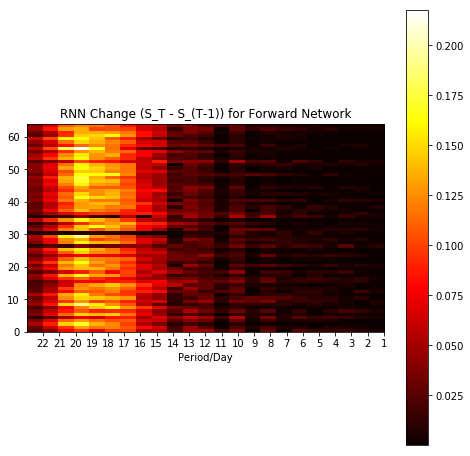

In [108]:
plt.figure()
fig, ax = plt.subplots(figsize=(8,8))
diff_plot = ax.imshow(np.absolute(np.diff(process_rnn_output_array_forward,axis=0)).T, cmap='hot',origin='lower', extent=[23,1,0,64])#,,origin='upper')
ax.set_aspect(0.2)
ax.set_xlabel('Period/Day')
ax.set_xticks(np.flip(np.arange(1,23),axis=0))
ax.set_title('RNN Change (S_T - S_(T-1)) for Forward Network')
cbar = fig.colorbar(diff_plot)
plt.show()

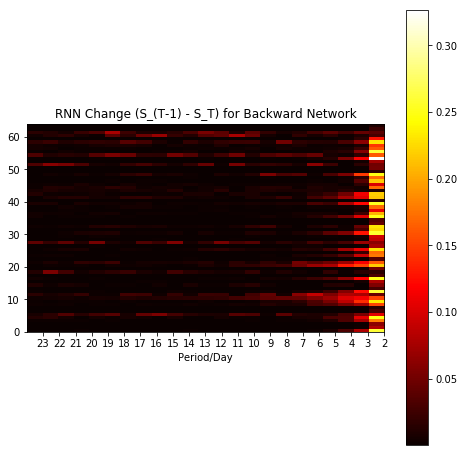

In [109]:
plt.figure()
fig, ax = plt.subplots(figsize=(8,8))
diff_plot = ax.imshow(np.absolute(np.flip(np.diff(np.flip(process_rnn_output_array_backward,axis=0),axis=0),axis=0)).T, cmap='hot',origin='lower', extent=[24,2,0,64])#,,origin='upper')
ax.set_aspect(0.2)
ax.set_xticks(np.flip(np.arange(2,24),axis=0))
ax.set_xlabel('Period/Day')
ax.set_title('RNN Change (S_(T-1) - S_T) for Backward Network')
cbar = fig.colorbar(diff_plot)
plt.show()